Ensemble Learning and Random Forests
----

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will
 often get better predictions than with the best individual predictor. A group of pre
dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an
 Ensemble Learning algorithm is called an Ensemble method.

As an example of an Ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you
obtain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest, 

### Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
 You may have a Logistic Regression classifier, an SVM classifier, a Random Forest
 classifier, a K-Nearest Neighbors classifier, and perhaps a few more

 A very simple way to create an even better classifier is to aggregate the predictions of
 each classifier and predict the class that gets the most votes. This majority-vote classi
fier is called a hard voting classifier

 Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

In [195]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


from sklearn.svm import SVC
from sklearn.datasets import make_moons, load_iris, fetch_openml
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor

In [196]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [197]:
# instances of the classifiers algo.

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

###### hard voting

In [198]:
# putting them together

voting_clf = VotingClassifier(
    # change 'hard' to 'soft' for prob considerations. Thats if all classifiers use dict_prob(), note SVC has no dict_prob()
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [199]:
# assesing the accuracy score of the classifiers

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)  # use predict_prob if 'soft' is  used above
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

#   The voting classifier slightly outperforms all the individual classifiers.

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


###### soft voting

In [200]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [201]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


#### Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms,
 as just discussed. Another approach is to use the same training algorithm for every
 predictor and train them on different random subsets of the training set.

When sampling is performed with replacement, this method is called bagging (short for boot
strap aggregating). When sampling is performed without replacement, it is called pasting.

Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel.
This is one of the reasons bagging and pasting are such popular methods: they scale very well

In [202]:
# this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False

bag_clf = BaggingClassifier(DecisionTreeClassifier(
), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [203]:
print(accuracy_score(y_test, y_pred))

0.92


In [204]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [205]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

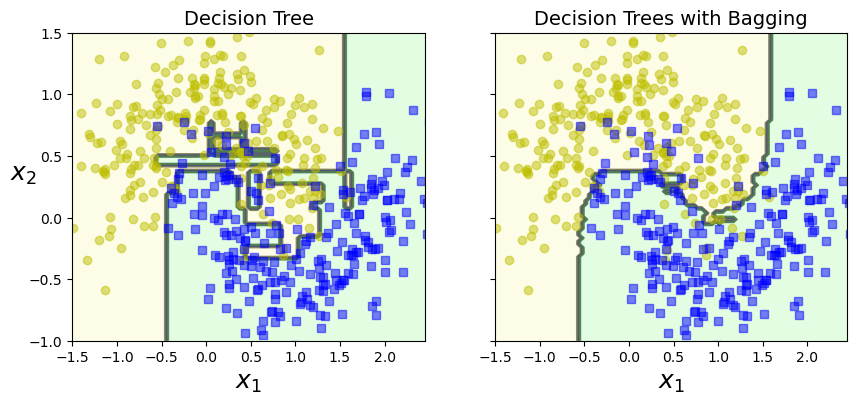

In [206]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

##### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor,
 while others may not be sampled at all. By default a BaggingClassifier samples m
 training instances with replacement (bootstrap=True), where m is the size of the
 training set. This means that only about 63% of the training instances are sampled on
 average for each predictor.6 The remaining 37% of the training instances that are not
 sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
 for all predictors.

You can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training. 

In [207]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(
), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

# According to this oob evaluation, this BaggingClassifier is likely to achieve about accuracy level close the value below

0.9013333333333333

In [208]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

In [209]:
# we can also obtain the prob of the individual instances

bag_clf.oob_decision_function_

array([[0.44827586, 0.55172414],
       [0.37222222, 0.62777778],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.0591716 , 0.9408284 ],
       [0.35675676, 0.64324324],
       [0.00952381, 0.99047619],
       [0.98522167, 0.01477833],
       [0.97765363, 0.02234637],
       [0.77486911, 0.22513089],
       [0.0097561 , 0.9902439 ],
       [0.80107527, 0.19892473],
       [0.815     , 0.185     ],
       [0.95930233, 0.04069767],
       [0.04268293, 0.95731707],
       [0.        , 1.        ],
       [0.97740113, 0.02259887],
       [0.95744681, 0.04255319],
       [0.97714286, 0.02285714],
       [0.03296703, 0.96703297],
       [0.32512315, 0.67487685],
       [0.90804598, 0.09195402],
       [1.        , 0.        ],
       [0.98378378, 0.01621622],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65895954, 0.34104046],
       [0.

#### Random Forests

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees.

In [210]:
rnd_clf = RandomForestClassifier(
    n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [211]:
#  This is similar to the RandomForestClassifier above

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16), n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

#### Feature Importance

 Another great quality of Random Forests is that they make it easy to measure the
 relative importance of each feature

In [212]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

# so we see that the petal lenth and width are the most important features.

sepal length (cm) 0.103875842655312
sepal width (cm) 0.025563314999300465
petal length (cm) 0.432418394568977
petal width (cm) 0.4381424477764106


In [213]:
# for the MNIST dataset we have

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [214]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

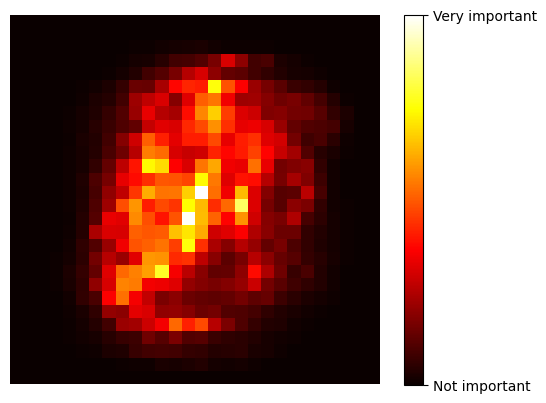

In [215]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")


plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(
    ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

##### Note:  Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

### Boosting 

 Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most
 boosting methods is to train predictors sequentially, each trying to correct its predecessor. common ones are - AdaBoost, Gradient Boosting

##### AdaBoost

In [216]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

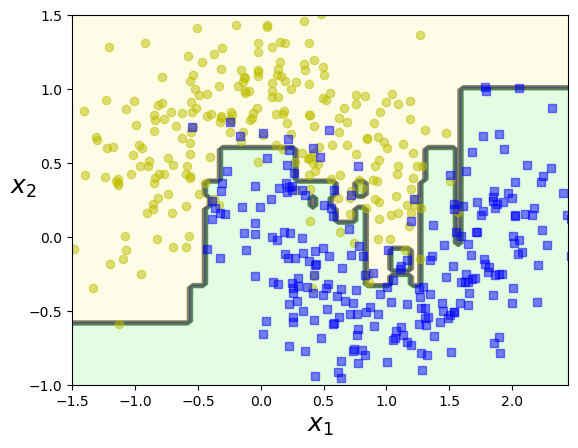

In [217]:
plot_decision_boundary(ada_clf, X, y)

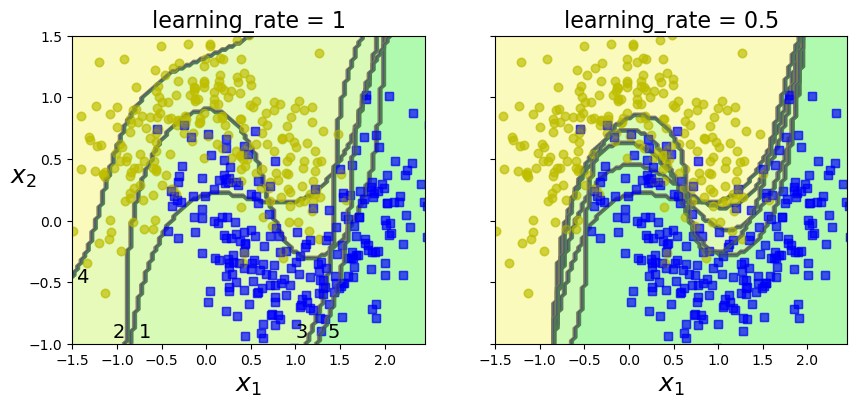

In [218]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum(
        ) / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

##### Gradient Boosting

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [219]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

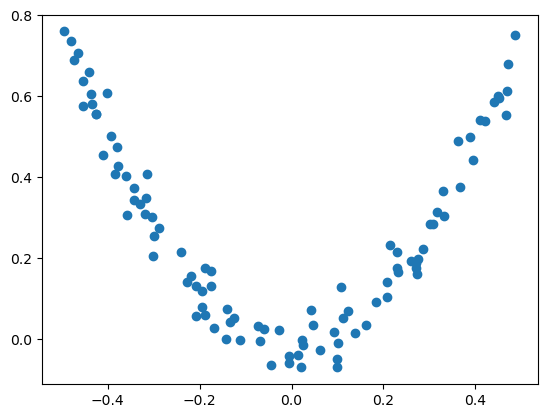

In [220]:
plt.scatter(X, y)

In [221]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [222]:
# we will train a second model on the redidual errors of the first
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [223]:
#  Then we train a third regressor on the residual errors made by the second predictor.

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [224]:
# Now we have an ensemble containing three trees. It can make predictions on a newinstance simply by adding up the predictions of all the trees
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)


[0.75026781]


In [225]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

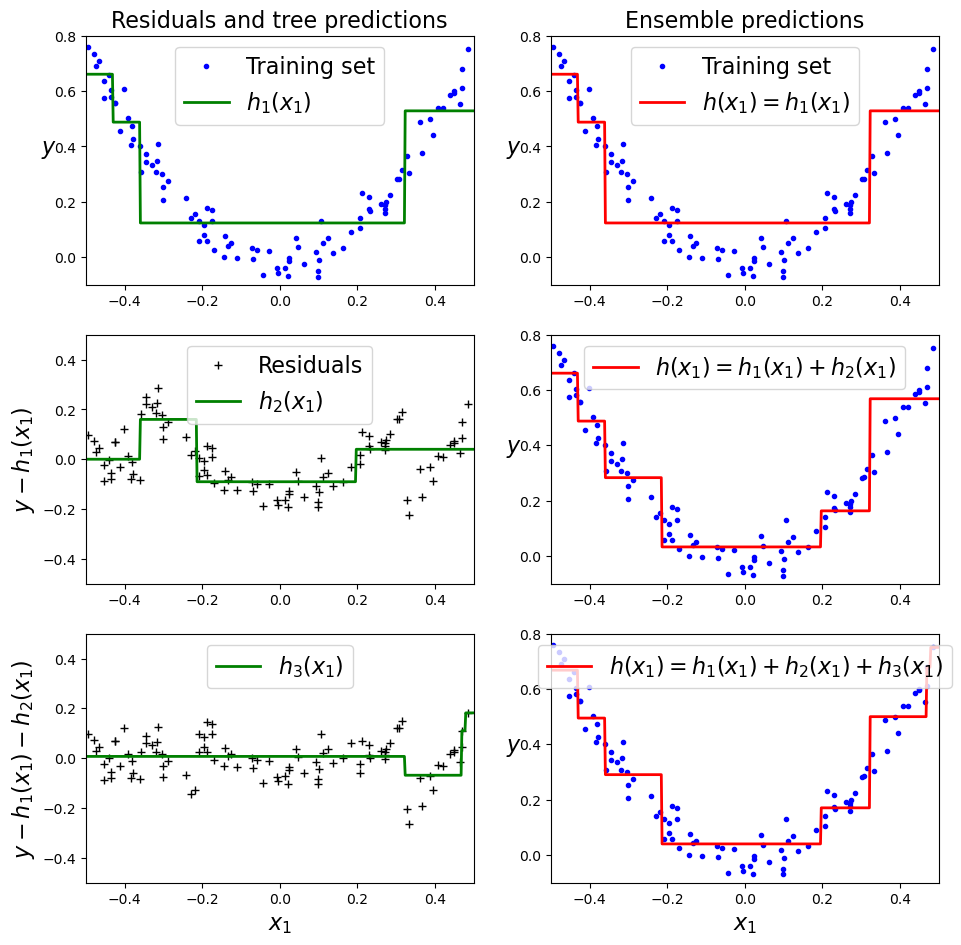

In [226]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()


# Represents the predictions of these three trees in the left column, and the
# ensemble’s predictions in the right column. In the first row, the ensemble has just one
# tree, so its predictions are exactly the same as the first tree’s predictions. In the second
# row, a new tree is trained on the residual errors of the first tree. On the right you can
# see that the ensemble’s predictions are equal to the sum of the predictions of the first
# two trees. Similarly, in the third row another tree is trained on the residual errors of
# the second tree. You can see that the ensemble’s predictions gradually get better as
#  trees are added to the ensemble.

In [227]:
# using  GradientBoostingRegressor it has hyperparameters to control the growth of Decision Trees (e.g., max_depth, min_samples_leaf), as well as
# hyperparameters to control the ensemble training, such as the number of trees (n_estimators).

# The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the train
# ing set, but the predictions will usually generalize better

gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [228]:
gbrt_slow = GradientBoostingRegressor(
    max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

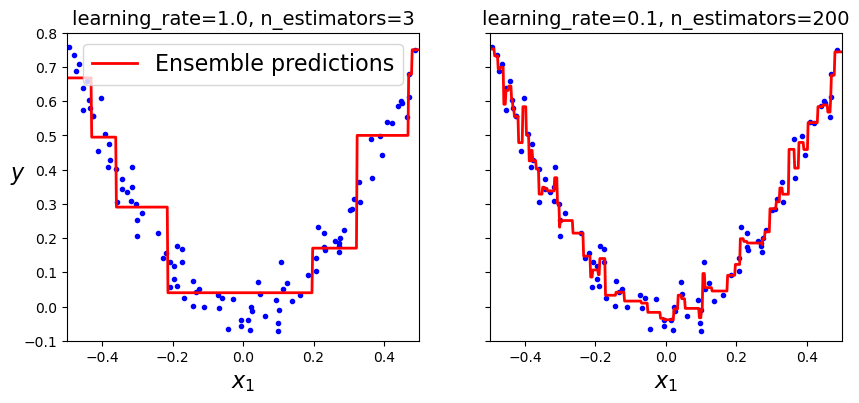

In [229]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In order to find the optimal number of trees, you can use early stopping

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [232]:
min_error = np.min(errors)
min_error

0.002712853325235463

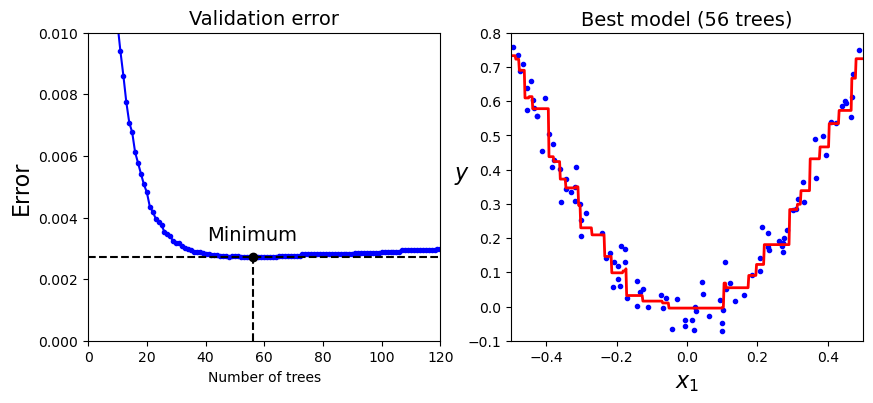

In [233]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). Here u can set "warm_start=True"

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

61
